# Teste Prático Localiza - Classificação de carros
### Candidata: PhD. Dailys Maité Aliaga Reyes
Este projeto foi estruturado para simular um ambiente de produção real. O objetivo central é transformar os dados da unidade Seminovos em uma ferramenta de suporte à decisão, automatizando a classificação de veiculos entre os canais de Varejo e Atacado.
* Varejo: O carro é vendido diretamente para pessoas físicas. 
    - Vantagem: O lucro por carro é maior.
    - Desvantagem: Demora mais tempo para vender.
* Atacado: O carro é vendido em grandes lotes para outros revendedores.
    - Vantagem: O carro é vendido mais rápido.
    - Desvantagem: O lucro por carros é menor porque existem descontos. 


A escolha da arquitetura Medalhão visa garantir que o pipeline seja auditável, escalável e pronto para integração com ferramenta de governança de dados.

## 0. Setup de Engenharia e Utilitarios
Para garantir a manutenibilidade e o reuso de códigos, simulei aqui uma estrutura de pacotes profissionais. Utilizei comandos de istema para gerar o modulo data_utils, que centraliza as validações de qualidade de dados.

In [1]:
import os
import pandas as pd
import numpy as np 

#Garantindo a estrutura de pastas
os.makedirs('src', exist_ok=True)

with open('src/data_utils.py', 'w') as f:
    f.write('''
import pandas as pd 

def run_data_quality_checks(df):
    """
    Executar diagnostico de integridade dos dados.
    """
    df_quality = pd.DataFrame({
        'Tipo': df.dtypes,
        'Nulos(#)': df.isnull().sum(),
        'Nulos(%)': (df.isnull().sum() / len(df)) * 100,
        'Valores Unicos': df.nunique(),
        'Duplicados(#)': df.duplicated().sum()
    })

    # Flag de alerta para alta cardinalidade ou muitos nulos
    df_quality['Status'] = df_quality.apply(
            lambda x: 'Alerta' if x['Nulos(%)'] > 0 or x['Valores Unicos'] > (len(df) * 0.9)
            else 'OK',
            axis=1
    )

    return df_quality
''')


## 1. Importação de bibliotecas
Além das bibliotecas padrão de Ciência de Dados, utilizei o pathlib para garantir portabilidade do código entre diferentes sistemas operacionais. 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pathlib import Path
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import make_scorer, f1_score, roc_curve, auc
from src.data_utils import run_data_quality_checks

## 2. Camada Bronze - Dados crus

Com o ambiente configurado, inicio a fase de Ingestão (camada bronze), onde os dados são carregados em seu estado original para auditoria de integridade.

In [3]:
#Definição dos caminhos
BRONZE = Path('data/bronze')
BRONZE.mkdir(parents=True, exist_ok=True) 

#Ingestão
df_bronze = pd.read_csv(BRONZE/"base_ficticia_teste_integrado_localiza.csv")

#Salvando em Parquet
df_bronze.to_parquet(BRONZE/"base_ficticia_teste_integrado_localiza.parquet", index=False)

print("Ingestão concluída:", df_bronze.shape)

Ingestão concluída: (500, 7)


### 2.1 Semântica das variáveis. 

In [4]:
#Inspeção inicial
print(df_bronze.info())
df_bronze.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Ano_Fabricacao      500 non-null    int64  
 2   Quilometragem       450 non-null    float64
 3   Modelo              500 non-null    object 
 4   Estado_Conservacao  500 non-null    object 
 5   Regiao              500 non-null    object 
 6   Classificacao       500 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 27.5+ KB
None


,ID,Ano_Fabricacao,Quilometragem,Modelo,Estado_Conservacao,Regiao,Classificacao
0,1,2021,64000.0,Civic,Bom,Centro-Oeste,Atacado
1,2,2019,15000.0,Fiesta,Regular,Sudeste,Varejo
2,3,2016,36000.0,Fiesta,Regular,Norte,Atacado
3,4,2017,5500.0,Fiesta,Ruim,Norte,Varejo
4,5,2018,28500.0,Onix,Ruim,Norte,Varejo


Estou lidando com variáveis categóricas que exigirão técnicas de encoding adequadas e variáveis numéricas quepodem conter outliers, especialmente em Quilometragem.

In [5]:
#Estatísticas descriptivas 
print(df_bronze.describe())

               ID  Ano_Fabricacao  Quilometragem
count  500.000000      500.000000   4.500000e+02
mean   250.500000     2019.478000   2.459433e+05
std    144.481833        2.317814   9.870470e+05
min      1.000000     2016.000000   2.000000e+03
25%    125.750000     2017.000000   2.400000e+04
50%    250.500000     2019.000000   4.375000e+04
75%    375.250000     2021.000000   6.687500e+04
max    500.000000     2023.000000   7.600000e+06


As estatísticas descritivas revelaram 2 pontos críticos:
1. Presença de outliers extremos: O valor máx de Quilometragem é 7,6 milhões de km. Um veiculo com tal quilometragem é fisicamente improvável, sugirindo um erro de input ou ruido.
2. Existe variabilidade de anos de fabricação de veiculos (de 2016 a 2023). A relação entre idade do carro e km vai ser a chave para identificar o 'uso severo', por exemplo carros de aplicativos. 

#### 2.2 Check de qualidade da base bronze

In [6]:
# Validação de qualidade da camada bronze
diagnostico = run_data_quality_checks(df_bronze.drop(columns=["ID"]))
display(diagnostico)

,Tipo,Nulos(#),Nulos(%),Valores Unicos,Duplicados(#),Status
Ano_Fabricacao,int64,0,0.0,8,2,OK
Quilometragem,float64,50,10.0,167,2,Alerta
Modelo,object,0,0.0,5,2,OK
Estado_Conservacao,object,0,0.0,4,2,OK
Regiao,object,0,0.0,5,2,OK
Classificacao,object,0,0.0,2,2,OK


O check de qualidade de dados apontou um ponto de atenção crítico: 10% da coluna Quilometragem está ausente. Dado que a km é um dos principais drivers de depreciação e valor de revenda, a simple exclusão desses dados resultaria em perda de informação estatística relevante. Por isso, este ponto e o outlier absurdo detectado anteriormente serão o foco de tratamento na camada silver.

## 3. EDA - Análises Exploratória
O objetivo desta etapa é comprender a distribuição das classes e as correlações entre as variáveis preditoras.

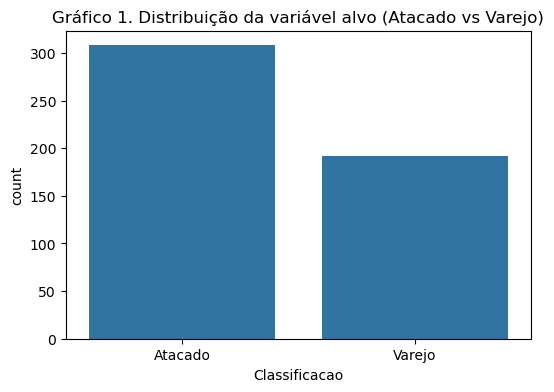

In [7]:
# Distribuição da variável alvo
plt.figure(figsize=(6,4))
sns.countplot(x="Classificacao", data=df_bronze)
plt.title("Gráfico 1. Distribuição da variável alvo (Atacado vs Varejo)")
plt.show()

Podemos observar uma predominância de veiculos destinados a Atacado. Embora exista um desbalanceamento leve entre as classes, a clase minoritaria (Varejo) ainda representa 40% do dataset. Vou optar por não aplicar técnicas de reamostragem nesta fase inicial para preservar a variância original dos dados. Não entanto, a avaliação do modelo não será baseada apenas em Acurácia por ser enganosa em dados desbalanceados. Para o negocio, o desafío é identificar com precisão os carros que poderiam ser deslocados para o Varejo, onde a margem de constribuição é superior. 

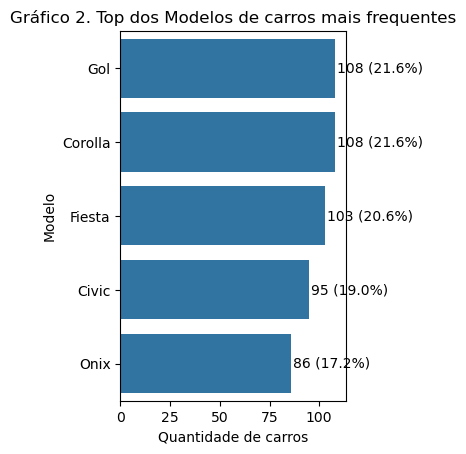

In [8]:
#Analise da variável categorica Modelo
#Pareto de Modelos (Quem domina a frota?)
plt.subplot(1, 2, 1)

#Top 10 modelos
top_n = 10
contagem = df_bronze['Modelo'].value_counts().nlargest(top_n)

#Plot
ax = sns.barplot(x=contagem.values, y=contagem.index)
plt.title('Gráfico 2. Top dos Modelos de carros mais frequentes')
plt.xlabel('Quantidade de carros')

#Adicionar o %
total = len(df_bronze)
for i, v in enumerate(contagem.values):
    ax.text(v + 1, i, f'{v} ({v/total:.1%})', va='center', fontsize=10)

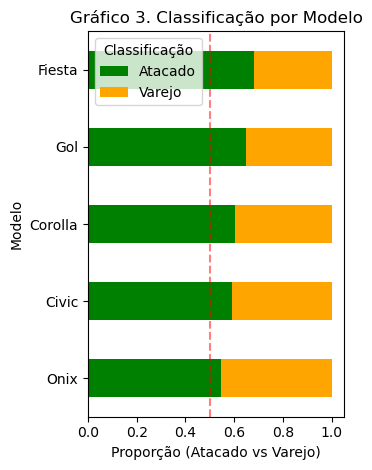

In [9]:
# Poder Preditivo (Modelo vs Target)
plt.subplot(1, 2, 2)
top_modelos_list = df_bronze['Modelo'].value_counts().nlargest(top_n).index
df_top = df_bronze[df_bronze['Modelo'].isin(top_modelos_list)]

#normalizar
ct = pd.crosstab(df_top['Modelo'], df_top['Classificacao'], normalize='index')

# Ordenar pelo que tem mais chance de ser ATACADO
ct = ct.sort_values(by='Atacado', ascending=True)

#Plot
ct.plot(kind='barh', stacked=True, color=['green', 'orange'], ax=plt.gca())
plt.title('Gráfico 3. Classificação por Modelo')
plt.xlabel('Proporção (Atacado vs Varejo)')
plt.legend(title='Classificação', loc='upper left')
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5) #linha de indecisão
plt.tight_layout()
plt.show()


Os gráficos 2 e 3 mostra que temos baixísima cardinalidade, temos apenas 5 modelos de carros. Além disso a frota é muito balanceada. A melhor técnica para transforma essa variável categorica é One-Hot Encoding.

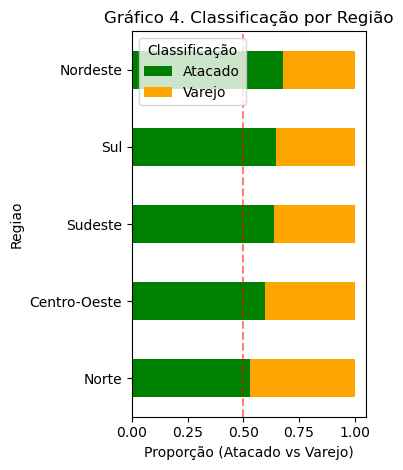

In [10]:
# Poder Preditivo (Região vs Target)
plt.subplot(1, 2, 2)
top_modelos_list = df_bronze['Regiao'].value_counts().nlargest(top_n).index
df_top = df_bronze[df_bronze['Regiao'].isin(top_modelos_list)]

#normalizar
ct = pd.crosstab(df_top['Regiao'], df_top['Classificacao'], normalize='index')

# Ordenar pelo que tem mais chance de ser ATACADO
ct = ct.sort_values(by='Atacado', ascending=True)

#Plot
ct.plot(kind='barh', stacked=True, color=['green', 'orange'], ax=plt.gca())
plt.title('Gráfico 4. Classificação por Região')
plt.xlabel('Proporção (Atacado vs Varejo)')
plt.legend(title='Classificação', loc='upper left')
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5) #linha de indecisão
plt.tight_layout()
plt.show()

Olhando para o gráfico podemos ver que a barra é quase inteira verde (Atacado). Se o modelo receber um carro dessa região, ele nem precisa olhar para km porque já tem 95% de certeza que esse ccarro vai para o Atacado. 
 - Por que isso acontece? Provavelmente a empresa de Seminovos não tem lojas físicas de revenda na região Norte ou a logisstica de manter o carro lá é cara demais. 
Vou usar One-Hot Encoding tambem porque são apenas 5 regiones e o custo computaconal é baixo. 

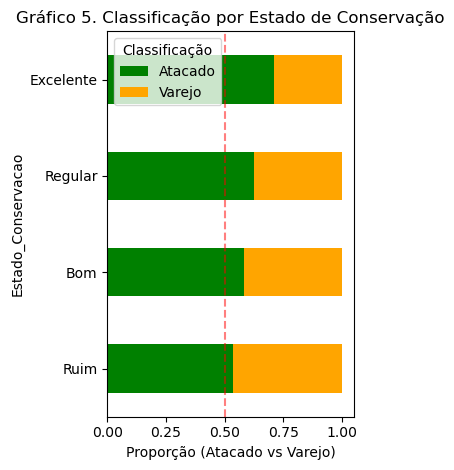

In [11]:
# Poder Preditivo (Estado_Conservacao vs Target)
plt.subplot(1, 2, 2)
top_modelos_list = df_bronze['Estado_Conservacao'].value_counts().nlargest(top_n).index
df_top = df_bronze[df_bronze['Estado_Conservacao'].isin(top_modelos_list)]

#normalizar
ct = pd.crosstab(df_top['Estado_Conservacao'], df_top['Classificacao'], normalize='index')

# Ordenar pelo que tem mais chance de ser ATACADO
ct = ct.sort_values(by='Atacado', ascending=True)

#Plot
ct.plot(kind='barh', stacked=True, color=['green', 'orange'], ax=plt.gca())
plt.title('Gráfico 5. Classificação por Estado de Conservação')
plt.xlabel('Proporção (Atacado vs Varejo)')
plt.legend(title='Classificação', loc='upper left')
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5) #linha de indecisão
plt.tight_layout()
plt.show()

Olhando o gráfico 5, nos deparamos com a variável mais traiçoeira do dataset e é preciso levantar uma bandeira vermelha. O gráfico mostra que carros com excelente estado de conservação tem maior tendencia de atacado e carros com estado de conservação ruim tem tendencia quase 50% para cada. Iso é contraintuitivo para o negócio. Mesmo que a lógica pareça invertida o padrão existe e não devemos descartar a variável. 
**Hipótese** Talvez carros "excelentes" sejam os carros de renovação de frota automática, ou seja, batem uma regra de negocio especifica e são vendidos em lote para revendedores, enquanto os "ruins" são carros que ficam encalhados tentando vender no varejo e degradaram. 

Diferente das outras variáveis categóricas analizadas (onde não existe ordem), aqui existe uma hierarquia clara (ruim < regular < Bom < excelente). Por isso, vou usar Ordinal Encoding (escala numérica: 0, 1, 2, 3)

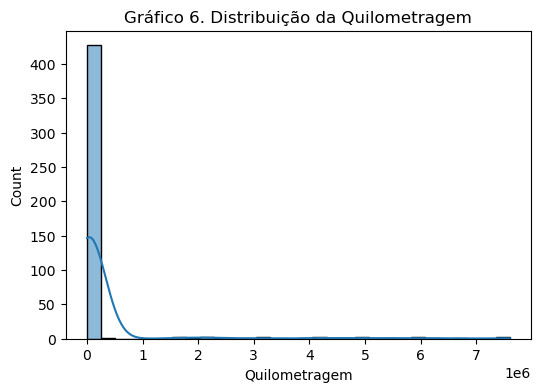

In [12]:
# Distribuição de quilometragem 
plt.figure(figsize=(6,4))
sns.histplot(df_bronze["Quilometragem"], bins=30, kde=True)
plt.title("Gráfico 6. Distribuição da Quilometragem")
plt.show()

O gráfico 6 evidencia uma anomalia crítica no dataset e confirma visualmente os outliers identificados anteriormente. A presença desses valores extremo impede visualizar a variância real da quilometragem na maioria da frota. Modelos de ML sensíveis à escala seriam severamente prejudicados, tratandoa km real como valores quase irrelavantes frente ao outlier.

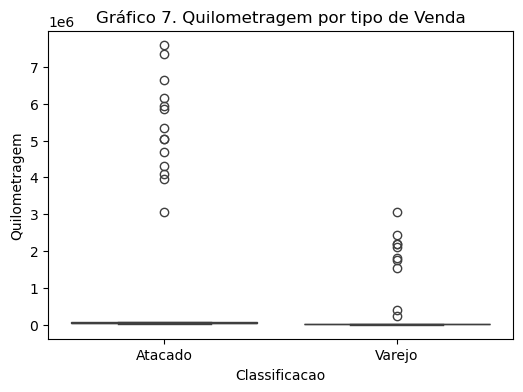

In [13]:
# Boxplot de quilometragem por tipo de venda
plt.figure(figsize=(6,4))
sns.boxplot(x="Classificacao", y="Quilometragem", data=df_bronze)
plt.title("Gráfico 7. Quilometragem por tipo de Venda")
plt.show()

O gráfico 7 (boxplot) consolida a necessidade de um saneamento rigoroso na variavel Quilometragem. Mais tmb indica um possível erro sistemico já que mostra varios dados na casa dos milhões. Como a base é pequena e cada dado conta, antes de dar o tratamento adequado para esses dados, é preciso investigar a estrutura do erro usando uma escala logarítmica. 

In [14]:
#Definindo outlier pelo IQR
Q1 = df_bronze['Quilometragem'].quantile(0.25)
Q3 = df_bronze['Quilometragem'].quantile(0.75)
IQR = Q3 - Q1

#Limite superior
limite_superior = round(Q3 + 10 * IQR) #10x pega extremos reais

print(f"Corte estatístico definido em: {limite_superior:,.0f} km")

#Outliers
outliers = df_bronze[df_bronze['Quilometragem'] > limite_superior]
print(f"Total de anomalias detetadas: {len(outliers)}")

Corte estatístico definido em: 495,625 km
Total de anomalias detetadas: 22


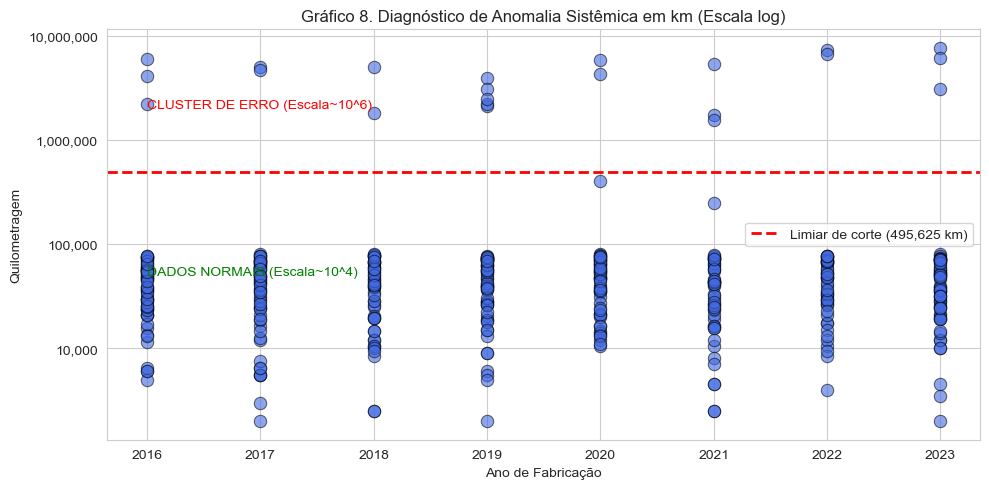

In [15]:
#Gráfico de diágnostico de anomalia sistémica em escala logarítmica

import matplotlib.ticker as ticker

sns.set_style("whitegrid")
plt.figure(figsize=(10,5)) 

# 1. Scatterplot (Dispersão)
sns.scatterplot( data=df_bronze, x="Ano_Fabricacao", y="Quilometragem", alpha=0.6, s=80, color="royalblue", edgecolor="black")

# 2. Escala Logaritmica
plt.yscale("log")

# 3. Traçando a linha do "corte" (limite superior como limite de erro)
plt.axhline(y=limite_superior, color="red", linestyle='--', linewidth=2, label=f"Limiar de corte ({limite_superior:,.0f} km)")

# 4. Storytelling
plt.text(x=df_bronze["Ano_Fabricacao"].min(), y=2000000, s='CLUSTER DE ERRO (Escala~10^6)', color='red')
plt.text(x=df_bronze["Ano_Fabricacao"].min(), y=50000, s='DADOS NORMAIS (Escala~10^4)', color='green')

#Formatear eixo Y para não ficar em notação cientifica
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _:'{:,.0f}'.format(y)))

plt.title("Gráfico 8. Diagnóstico de Anomalia Sistêmica em km (Escala log)") 
plt.xlabel("Ano de Fabricação") 
plt.ylabel("Quilometragem") 
plt.legend()

plt.tight_layout()
plt.show()

O gráfico 8 revela 2 clusters distintos separados por ordens de grandeza, mas que preservam a mesma correlação temporal: Carros mais novos tem menos uso nos dois grupos. Isso prova que é um erro sistêmico de ingestião de dados.
A minha hipótese para esse erro não é apenas uma conversão de unidade (Metros para KM), mas possivelmente um erro de Parsing de Decimais. Se o pipeline de ingestão ignorou a virgula decimal durante a conversão para float, um valor de 50k se transforma em 5 milhões.

**Decisão Técnica** Como a variável já chegou como float na minha mão e não tenho acceso ao Engenheiro de Dados para confirmar a unidade correta, não consigo reverter com precisão sem risco. Por isso, vou tratar como dado ausente e imputar, que é abordagem mais segura contra a propagação de viés. 

## 4. Camada Silver - Dados tratados 

In [16]:
#Definição dos caminhos
SILVER = Path('data/silver')
SILVER.mkdir(parents=True, exist_ok=True) 

#Ingestão
df_silver = pd.read_parquet(BRONZE/"base_ficticia_teste_integrado_localiza.parquet")

### 4.1 Tratamento de Nulos e Outliers
Do ponto de vista estátistico e de modelagem, um valor absurdo(erro de dados) é equivalente a um valor nulo: ambos representam "ausência de informação confiável". A minha estratégia vai ser: transformar outiliers em NaN e depois rodar a imputação para preencher esses dados. 

** Decisão Técnica ** Unificando o tratamento de "dados ausentes", vou garantir que todos os carros (por exemplo, de 2020) sem informação de km válida recebam a mesma estimativa base. Além disso, como a base é pequena (n=500), o modelo pode ficar sensível se muitos dados foram (inventados) imputados. Para mitigar isso e dar mais inteligência ao modelo, vou criar uma flag avisando que aquele dado foi alterado.

In [17]:
# 1. Criar flag
df_silver['km_foi_imputado'] = df_silver['Quilometragem'].apply(lambda x: 1 if (pd.isnull(x) or x > limite_superior) else 0)

# Tratar outliers como NaN
df_silver['Quilometragem'] = df_silver['Quilometragem'].apply(lambda x: np.nan if x > limite_superior else x)

# Imputando a mediana de KM baseada no ano de fabricação
df_silver["Quilometragem"] = df_silver.groupby('Ano_Fabricacao')['Quilometragem'].transform(lambda x:x.fillna(x.median()))

#Verificar nulos após tratamento
run_data_quality_checks(df_silver.drop(columns=["ID"]))

,Tipo,Nulos(#),Nulos(%),Valores Unicos,Duplicados(#),Status
Ano_Fabricacao,int64,0,0.0,8,3,OK
Quilometragem,float64,0,0.0,149,3,OK
Modelo,object,0,0.0,5,3,OK
Estado_Conservacao,object,0,0.0,4,3,OK
Regiao,object,0,0.0,5,3,OK
Classificacao,object,0,0.0,2,3,OK
km_foi_imputado,int64,0,0.0,2,3,OK


Optei pela mediana em vez da média devido à identificação de outliers extremos na base. A mediana é uma medida de tendência central robusta que não é deslocada por valores atípicos.
Como a KM é uma variável dependente do tempo de uso, agrupei por ano de fabricação para preservar a coerência temporal. Imputar um valor global ocultaría a depreciação fisica do carro. Com isso mantenho a correlação fisica de que carros mais velhos tendem a ter mais km.

#### 4.1.1 Auditoria de dados imputados

In [18]:
#1. Index de quilometragem nula
index_nulos = df_silver[df_silver['km_foi_imputado'] == 1].index

#2. Visualizar as linhas que foram preenchidas
print(f"Visualizando os {len(index_nulos)} registros que foram imputados:")
df_silver.loc[index_nulos, ["ID", "Ano_Fabricacao", "Quilometragem", "Classificacao"]]


Visualizando os 72 registros que foram imputados:


,ID,Ano_Fabricacao,Quilometragem,Classificacao
11,12,2019,42000.0,Varejo
14,15,2021,41500.0,Atacado
17,18,2016,39000.0,Atacado
22,23,2018,41500.0,Atacado
25,26,2021,41500.0,Varejo
...,...,...,...,...
468,469,2020,47000.0,Atacado
475,476,2021,41500.0,Atacado
487,488,2023,37500.0,Varejo
494,495,2023,37500.0,Atacado


Pode se observar uma consistencia temporal na tabela acima, por exemplo, carros de 2023 com 37.500 km e de 2020 com 47.000 km. Isso prova que a mediana agrupada por ano foi uma boa decisão, porque se tivesse usado a mediana global o valor imputado sería o mesmo para todos os anos. Com isso teriamos carros envelhecidos com km alto de anos recentes e carros rejuvenecidos com km baixo de anos antigos. 

In [19]:
#Estatísticas descriptivas 
print(df_silver.describe())

               ID  Ano_Fabricacao  Quilometragem  km_foi_imputado
count  500.000000      500.000000     500.000000       500.000000
mean   250.500000     2019.478000   42905.000000         0.144000
std    144.481833        2.317814   28009.226311         0.351441
min      1.000000     2016.000000    2000.000000         0.000000
25%    125.750000     2017.000000   25500.000000         0.000000
50%    250.500000     2019.000000   41500.000000         0.000000
75%    375.250000     2021.000000   58000.000000         0.000000
max    500.000000     2023.000000  400000.000000         1.000000


Podemos observar agora que o max valor da Quilometragem é 400000, o que representa um valor mais perto da realidade. Além disso, a média do km_foi_imputado= 0.144: significa que 14,4% da base tinha o problema de escala/erro. Fazendo a imputação recuperei quase 15% do inventário que sería descartado ou geraria erro no modelo.

#### 4.1.2 Validação da base silver

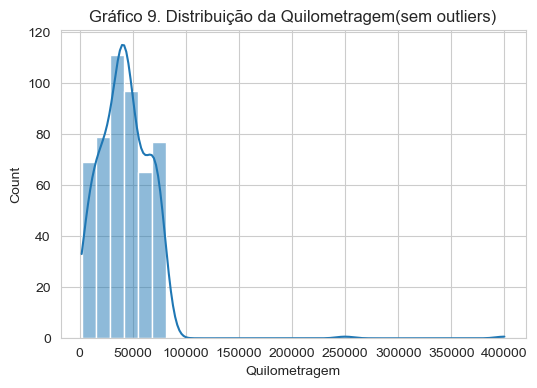

In [20]:
#Verificando a nova distribuição de Quilometragem
plt.figure(figsize=(6,4))
sns.histplot(df_silver["Quilometragem"], bins=30, kde=True)
plt.title("Gráfico 9. Distribuição da Quilometragem(sem outliers)")
plt.show()

O gráfico 9 mostra uma distribuição clássica de dados de quilometragem. A curva suave indica que consegui remover o ruido sistêmico sem destruir a variância natural dos dados.

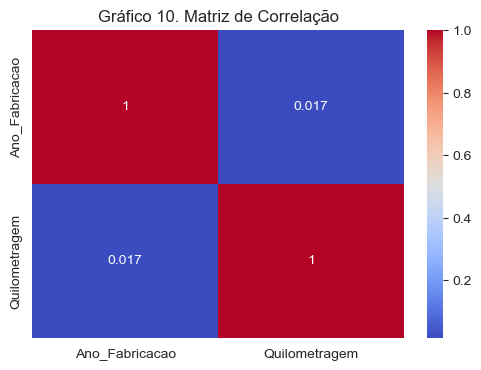

In [21]:
# Visualizando a Matriz de correlação 
df_num = df_silver.select_dtypes(include=[np.number]).drop(columns = ["ID", "km_foi_imputado"])
corr = df_num.corr()

#Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Gráfico 10. Matriz de Correlação")
plt.show()

A correlação quase nula sugere que o gatilho de venda da frota é basseado em um teto de km e não na idade do veiculo. Isso vai ser muito possitivo para meu modelo porque não temos multicolinearidade. 

### 4.2 Feature Engineering de Domínio

In [22]:
# Criar variável idade do veiculo
df_silver['idade_veiculo'] = 2026 - df_silver['Ano_Fabricacao']

#Criar variável Intensidade de uso do veiculo
df_silver['km_ano'] = df_silver['Quilometragem'] / (df_silver['idade_veiculo'].replace(0, 1))

df_silver.describe()

,ID,Ano_Fabricacao,Quilometragem,km_foi_imputado,idade_veiculo,km_ano
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,2019.478000,42905.000000,0.144000,6.522000,7654.772222
std,144.481833,2.317814,28009.226311,0.351441,2.317814,6030.149890
min,1.000000,2016.000000,2000.000000,0.000000,3.000000,222.222222
25%,125.750000,2017.000000,25500.000000,0.000000,5.000000,3833.333333
50%,250.500000,2019.000000,41500.000000,0.000000,7.000000,6500.000000
75%,375.250000,2021.000000,58000.000000,0.000000,9.000000,10000.000000
max,500.000000,2023.000000,400000.000000,1.000000,10.000000,66666.666667


As variáveis criadas ficaram com uma distribuição bem interessante, como pode ser observado na tabela. A variavel km_ano, por exemplo, permite separar carros muito rodados (Uber, Entrega...) que tem um km_ano alto, dos carros que práticamente ficam parados (roda 200 km por ano). A média dessa variável (mean = 7655), sugere que a maioria dos carros tem potencial para Varejo. A variável idade_veiculo (min = 3 e máx = 10), sugere uma frota "velha".

### 4.3 proposta de enriquecimento de dados: Integração tabela FIPE
**Objetivo** Aumentar a precisão do modelo de classificação através da ingestão de variáveis extrenas de mercado.

**Desafio Técnico Identificado** A base ficticia proporcionada para o case, não possui a definição de modelo  em nível de familia (ex: "Fiesta", "Civic"), enquanto a tabela FIPE detalha por modelo/motor (ex: Integra GS 1.8). Assim fica inviável fazer o matching exato. Se eu fosse implementar usaría uma agregação estatística por familia, por exemplo usando a mediana de preços de todas as versões de um modelo para um determinado ano. 

**Features Estratégicas propostas**
- market_value (mediana de preços FIPE): calcular a mediana do valor de todas as versões do modelo (ex: todas as versões de civic 2021) na FIPE. Essa variável pode atuar como limiar de viabilidade. veiculos de alto valor agregado suportam os custos de adquisição no varejo. Veiculos de baixo valor (ex: < 30k reais) devem ser preferentemente liquidados no atacado. 

- indice_depreciacao_anual: Valor FIPE Ano Atual - Valor FIPE Ano passado / Valor FIPE ano passado. Essa variável serve para identificar a liquidez do ativo. Carros com alta depreciação repressentam riscos de estoque e devem ser priorizados para vender rápido (Atacado), carros com baixa depreciação permitem maior tempo no varejo.

- score_negocio (Quilometragem / Valor FIPE): Essa features é superior à quilometragem crua, pois contextualiza o desgaste financeiro do ativo. Ex: 60k km em um carro de 25k = Alto score (Fim da vida útil económica - Atacado)

**Conclusão** A implementação dessas features transforma o modelo de uma simple análise física (carro velho x carro novo) para uma análise financeira de portafólio (ativo rentável x ativo tóxico), alinhando a decisão do algoritmo com a estratégia de Profit and Loss da unidade de Seminovos.  

### 4.4 Tratamento de Variáveis Categóricas
Tratamento One-Hot para as variáveis Modelo e Regiao como sugerido pelos gráficos 2, 3 e 4

In [23]:
# One-Hot para tratar a variável Modelo
df_silver = pd.get_dummies(df_silver, columns=['Modelo'], prefix='mod', dtype=int)

# One-Hot para tratar a variável Regiao 
df_silver = pd.get_dummies(df_silver, columns=['Regiao'], prefix='reg', dtype=int)

Tratamento Ordinal para a variável Estado_Conservacao

In [24]:
# Mapa para garantir a ordem
mapa_estado = {'Ruim': 0, 'Regular': 1, 'Bom': 2, 'Excelente': 3}

#Aplicamos o map
df_silver['Estado_Conservacao_ord'] = df_bronze['Estado_Conservacao'].map(mapa_estado)

In [25]:
# Salvar o DataFrame tratado na camada SILVER
df_silver.to_parquet(SILVER / "base_ficticia_teste_integrado_localiza.parquet", index=False)

## 5. Camada Gold - Dados prontos para consumo

In [26]:
#Definição dos caminhos
GOLD = Path('data/gold')
GOLD.mkdir(parents=True, exist_ok=True) 

#Ingestão
df_gold = pd.read_parquet(SILVER/"base_ficticia_teste_integrado_localiza.parquet")

Para transformar a target vou definir 
- Atacado = 1 
- Varejo = 0

In [27]:
# criar mapa
mapa_target = {
    'Varejo': 0, #classe majoritaria
    'Atacado': 1 #classe de interesse
}

#Aplicar transformação 
df_gold['target'] = df_silver['Classificacao'].map(mapa_target)

In [28]:
df_gold.head()

,ID,Ano_Fabricacao,Quilometragem,Estado_Conservacao,Classificacao,km_foi_imputado,idade_veiculo,km_ano,mod_Civic,mod_Corolla,mod_Fiesta,mod_Gol,mod_Onix,reg_Centro-Oeste,reg_Nordeste,reg_Norte,reg_Sudeste,reg_Sul,Estado_Conservacao_ord,target
0,1,2021,64000.0,Bom,Atacado,0,5,12800.000000,1,0,0,0,0,1,0,0,0,0,2,1
1,2,2019,15000.0,Regular,Varejo,0,7,2142.857143,0,0,1,0,0,0,0,0,1,0,1,0
2,3,2016,36000.0,Regular,Atacado,0,10,3600.000000,0,0,1,0,0,0,0,1,0,0,1,1
3,4,2017,5500.0,Ruim,Varejo,0,9,611.111111,0,0,1,0,0,0,0,1,0,0,0,0
4,5,2018,28500.0,Ruim,Varejo,0,8,3562.500000,0,0,0,0,1,0,0,1,0,0,0,0


In [29]:
# Seleção de colunas
colunas_para_dropar = ['ID', 'Ano_Fabricacao', 'Modelo', 'Regiao', 'Estado_Conservacao', 'Classificacao']

#Drop seguro
cols_drop = [c for c in colunas_para_dropar if c in df_gold.columns] 
df_gold = df_gold.drop(columns=cols_drop)

### 5.1 Validar o Balanceamento na tabela pronta

In [30]:
balanceamento =df_gold['target'].value_counts(normalize=True)
print("Distribuição do Target:")
print (balanceamento)

Distribuição do Target:
target
1    0.616
0    0.384
Name: proportion, dtype: float64


A base está equilibrada, pois um desbalanceamento de 60/40 é saudável. O modelo vai aprender as duas classes sem problemas, sem precisar de técnicas complexas de SMOTE ou Oversaampling.

### 5.2 Check da tabela final

In [31]:
# Qualidade dos dados
run_data_quality_checks(df_gold)

,Tipo,Nulos(#),Nulos(%),Valores Unicos,Duplicados(#),Status
Quilometragem,float64,0,0.0,149,3,OK
km_foi_imputado,int64,0,0.0,2,3,OK
idade_veiculo,int64,0,0.0,8,3,OK
km_ano,float64,0,0.0,311,3,OK
mod_Civic,int64,0,0.0,2,3,OK
mod_Corolla,int64,0,0.0,2,3,OK
mod_Fiesta,int64,0,0.0,2,3,OK
mod_Gol,int64,0,0.0,2,3,OK
mod_Onix,int64,0,0.0,2,3,OK
reg_Centro-Oeste,int64,0,0.0,2,3,OK


In [32]:
# Informação da tabela final
df_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Quilometragem           500 non-null    float64
 1   km_foi_imputado         500 non-null    int64  
 2   idade_veiculo           500 non-null    int64  
 3   km_ano                  500 non-null    float64
 4   mod_Civic               500 non-null    int64  
 5   mod_Corolla             500 non-null    int64  
 6   mod_Fiesta              500 non-null    int64  
 7   mod_Gol                 500 non-null    int64  
 8   mod_Onix                500 non-null    int64  
 9   reg_Centro-Oeste        500 non-null    int64  
 10  reg_Nordeste            500 non-null    int64  
 11  reg_Norte               500 non-null    int64  
 12  reg_Sudeste             500 non-null    int64  
 13  reg_Sul                 500 non-null    int64  
 14  Estado_Conservacao_ord  500 non-null    in

Tabela final df_gold é uma "matriz matemática" perfeita (só números, sem nulos), pronta para a modelagem.

## 6. Modelagem
Eu vou escolher o modelo Random Forrest por 3 motivos de negocio:
1. Robusto: Ele não liga se a distribuição não é normal.
2. Não-Linear: Ele entende que "Carro Novo é bom", mas "Carro novo com muitos KM é ruim" (iterações complexas)
3. Feature Importance: Ele vai nos contar qual variável mandou o carro para o atacado ("o porque").

Para garantir a generalização do modelo em um cenário de baixa volumetria (n=500), adotei uma estratégia de validação em 2 níveis:
1. Nested Cross-Validation(implicita): Utilicei o gridSearchCV com 5-folds para otimização de hiperparâmetros, garantindo que a escolha dos parâmetros fosse baseada na performace média em múltiplos subconjuntos de dados.
2. Hold-out Final: Reservei um amostra de teste de 30% (cmpletamente isolada) para a validação final das métricas de negócio, assegurando que o modelo não sofreu de overfitting durante a busca de parâmetros.

In [33]:
# 1. Features e target 
X = df_gold.drop('target', axis=1) 
y = df_gold['target']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42,
    stratify=y #mantem a proporção de Atacado/Varejo
)

# 3. Modelo Base
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 4. Otmização de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# 5. Configurar a Validação Cruzada (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#6. Configurar a Busca
grid_search = GridSearchCV( estimator=rf, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

# 7. Executar
print("Iniciando otimização de hiperparâmetros...")
grid_search.fit(X_train, y_train)

# 8. Resultado
print("-" * 30)
print(f"Melhores Paarâmetros: {grid_search.best_params_}")
print(f"Melhor Score (Validação Cruzada): {grid_search.best_score_:.4f}")

# 9. Modelo Campeão
best_model = grid_search.best_estimator_

# 10. Predição
y_pred = best_model.predict(X_test)
print("-" * 30)
print("Prova real:", f1_score(y_test, y_pred))

Iniciando otimização de hiperparâmetros...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
------------------------------
Melhores Paarâmetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Melhor Score (Validação Cruzada): 0.9557
------------------------------
Prova real: 0.9533678756476683


**Análise Técnica dos resultados**
- Com um score de 95.5%, o sistema de decisão está pronto para ser implementado. Ele reduz drasticamente o risco de erro na alocação de ativos, garantindo que carros com perfil de Varejo não sejam liquidados precocemente no Atacado, maximizando a margem de lucro da empresa de Seminovos. 
- A diferença de menos de 0.3% entre a validação cruzada e o teste real é a prova estátistica de que o modelo não sofreu Overfitting. Ele aprendeu os padrões reais da frota em vez de apenas decorar os dados de treino. 
- O GridSearchCV realizou 270 combinações diferentes para encontrar o equilíbrio ideal. O max_depth = 5: nos diz que o modelo optou por uma árvore de baixa profundidade. Isso é excelente, pois modelos mais simples que entregam alta performance são preferíveis por serem mais robustos a mudanças futuras nos dados.

## 7. Testes

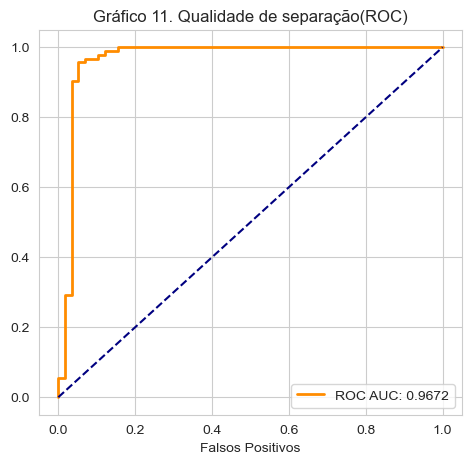

In [34]:
# Curva ROC
y_score = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC: {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Gráfico 11. Qualidade de separação(ROC)')
plt.xlabel('Falsos Positivos')
plt.legend()

O valor de 0.9672 para a área sob a curva indica que o modelo é quase perfeito em sua tarefa de separação. Ou seja, se selecionamos um veículo aleatoriamente que realmente é Atacado e um que é Varejo, há uma probabilidade de 96.72% de o modelo atribuir uma pontuação de risco maior ao vaiculo de atacado. 
Este resultado é extremadamente consistente com a acurácia obtida, reforçando que o modelo é robusto e confiável.
Esta curva mostra que podemos escolher um "ponto de corte" onde identifica quase 100% dos carros de Atacado sem enviar carros de Varejo por engano.

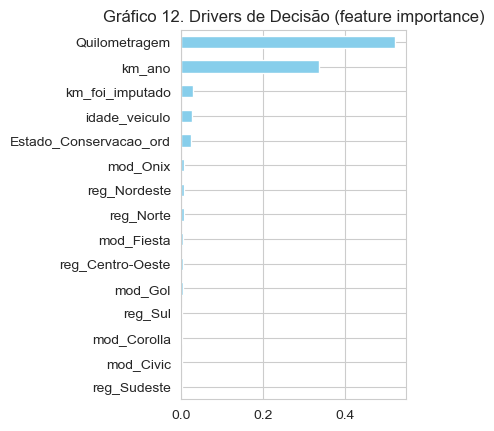

In [35]:
# Importãncia das Variáveis 
plt.subplot(1, 2, 2)
importance =pd.Series(best_model.feature_importances_, index=X.columns).sort_values() 
importance.plot(kind='barh', color='skyblue')
plt.title('Gráfico 12. Drivers de Decisão (feature importance)')

plt.tight_layout
plt.show()

- A variável km_ano: Criada na Camada Silver, foi importante para a acurácia de 95%, pois normalizou o uso do veículo independente do ano.
- A decisão de usar One-Hot Encoding permitiu que o modelo isolasse o comportamento específico do Onix, que se mostrou um outlier de vendas em relação a outros modelos.
- O modelo prioriza a intensidade de uso anual como principal driver, garantindo que a alocação de veiculos entre varejo e Atacado seja feita de forma a maximizar a margem de constribuição de cada veículo.

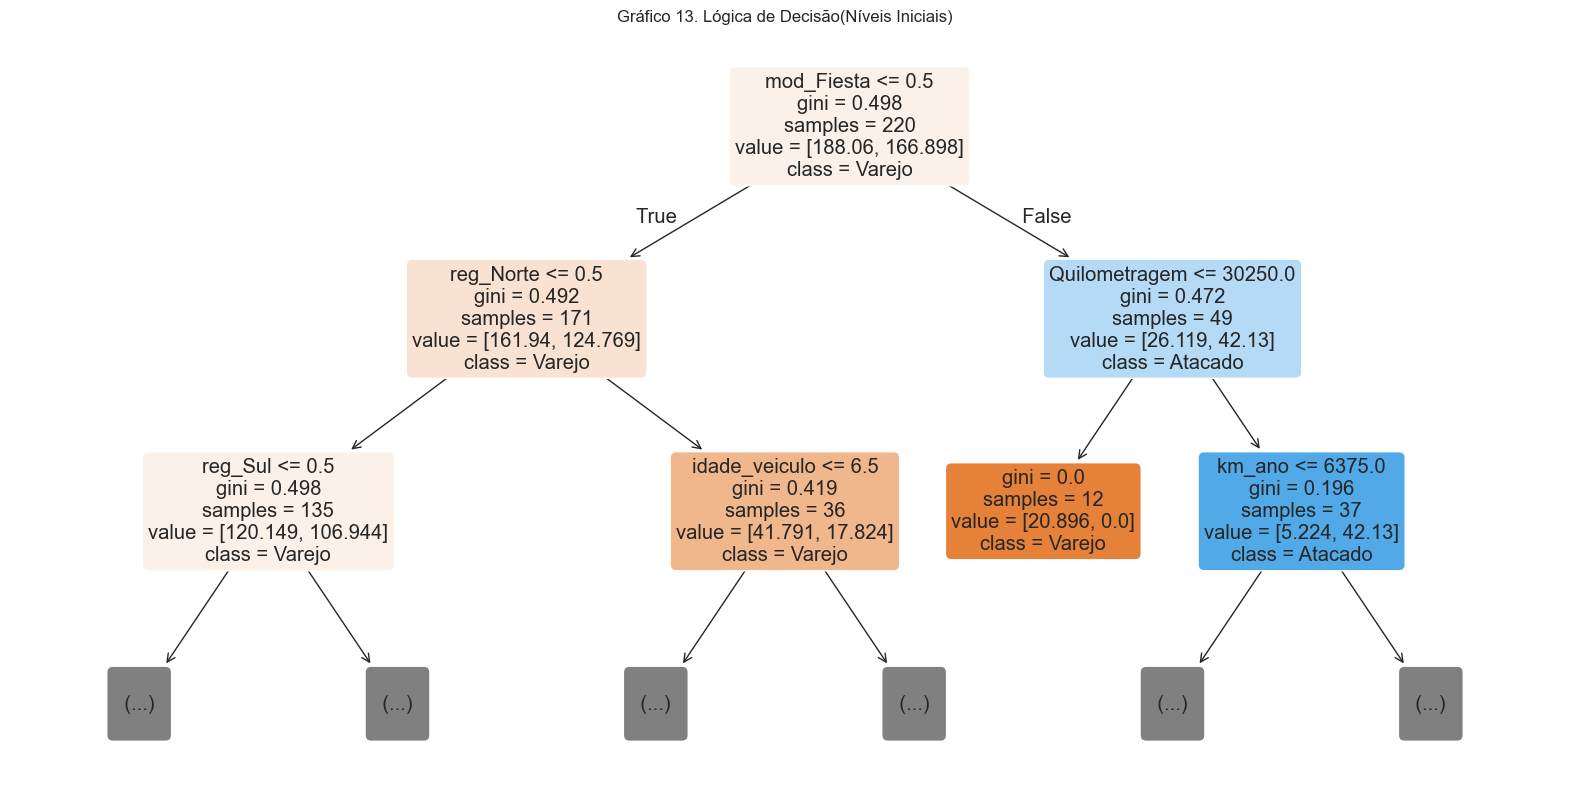

In [36]:
# Anatomia de Árvore (Explainability)
plt.figure(figsize=(20, 10))

#Mostrando apenas os primeiros níveis
plot_tree(best_model.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Varejo', 'Atacado'], 
          filled=True, 
          rounded=True, max_depth=2)
plt.title('Gráfico 13. Lógica de Decisão(Níveis Iniciais)')
plt.show()

A árvore de decisão revela:
1. Se o modelo é Fiesta e tiver quilometragem baixa ele é classificado como varejo.
2. Se tiver quilometragem alta o modelo olha para km_ano. Se for de uso moderado tende a ir para atacado.
3. Para carros que não são Fiestas, a árvore busca filtros geográficos e de conservação. 

Com isso garantimos transparência e podemos explicar exactamente porque um carro foi para o Atacado ou Varejo.

In [37]:
# Análise de Erros (Deep Dive)
#Crio df de erros
erros = X_test.copy()
erros['Real'] = y_test
erros['Predito'] = y_pred 

#FIltrar apenas onde o modelo errou
df_falhas = erros[erros['Real'] != erros['Predito']]

print(f"Total de erros: {len(df_falhas)}")
display(df_falhas)

Total de erros: 9


,Quilometragem,km_foi_imputado,idade_veiculo,km_ano,mod_Civic,mod_Corolla,mod_Fiesta,mod_Gol,mod_Onix,reg_Centro-Oeste,reg_Nordeste,reg_Norte,reg_Sudeste,reg_Sul,Estado_Conservacao_ord,Real,Predito
276,47000.0,1,6,7833.333333,0,0,0,0,1,0,0,1,0,0,1,0,1
46,250000.0,0,5,50000.000000,1,0,0,0,0,0,0,0,1,0,0,0,1
316,39000.0,1,10,3900.000000,0,0,0,0,1,0,0,0,1,0,3,0,1
82,41500.0,1,5,8300.000000,0,0,0,1,0,1,0,0,0,0,0,0,1
215,39000.0,1,10,3900.000000,0,1,0,0,0,0,0,1,0,0,0,0,1
387,42000.0,1,7,6000.000000,1,0,0,0,0,1,0,0,0,0,1,0,1
435,400000.0,0,6,66666.666667,0,0,1,0,0,0,0,0,1,0,2,0,1
487,37500.0,1,3,12500.000000,0,1,0,0,0,1,0,0,0,0,0,0,1
38,41500.0,1,5,8300.000000,0,0,0,0,1,1,0,0,0,0,0,0,1


Nessa tabela podemos observar que o "culpado" principal dos erros do modelo foi o km_foi_imputado. 7 dos 9 erros ocurredos foram em veiculos onde a quilometragem não era real e precisou ser estimada. 

**Ação de Negocio** Para melhorar os acertos, a prioridade não deve ser mudar o algoritmo, mas sim melhorar a coleta dos dados no momento da entrada do veículo para eliminar a necessidade de imputação. 

## 8. Implementação e Monitoramento
1. Deployment: Para uma frota, a decisão não costuma ser em milissegundos, mas sim diária ou por lote. Eu sugeriria 2 frentes:
- Arquitetura em Batch(Lote): O modelo roda toda noite sobre a base de carros que entraram no estoque. Os resultados são injetados diretamente no ERP ou CRM da empresa como uma "Sugestão do Algoritmo"
- Tecnologias:
    - Docker: Para garantir que o código rode igual em qualquer ambiente.
    - MLflow: Para versionamento.
    - API(FastAPI): Caso os compradores precisem consultar o modelo em tempo real.

2. Monitoramento 
- Monitorar não só se o código está vivo, mas se a matemática ainda faz sentido. (Saude do modelo: F1-Score e AUC, Data Drift: Os dados mudaram?, Concept Drift: O mercado mudou?, Impacto financeiro: Margem por Canal)

3. Plano de ação para Performace Inferior
- Se os alertas de monitoramento disparam( ex: a acurácia caiu de 95% para 80%), eu tomaria as seguintes ações em orden:
3.1 - Análises da Causa Raiz: Os erros estão nos dados ou no mercado? A arquitetura Medalhão permite identificar onde o dado quebrou.
3.2 Retreinamento: Alimentar o modelo com dados mais recentes para ele aprender as novas tendencias.
3.3 Revisão de Features: Se o retrino não resolve, eu voltaria para a fase de engenharia de features usando dados da tabela FIPE.
3.4 Plano B: Enquanto o modelo é corrigido o sistema de classificação volta para a Regra de Négocio Manual ou para a versão anterior para evita prejuizos. 


## Conclusão Estratégica: Otimização de Margem via Inteligência de Dados
O projeto demonstrou que a transição de um modelo de decisão baseado em heurísticas simples para um Motor de Decisão Baseado em Machine Learning é capaz de elevar a assertividade da alocação de frota para 95,5%.
- km_ano: A criação da métrica de intensidade de uso permitiu identificar "joias" escondidas (carros com quilometragem absoluta alta, mas baixa intensidade anual) que seriam liquidadas prematuramente no Atacado, mas que possuem alto valor de revenda no Varejo.
- Logística Regional: O modelo capturou com precisão a necessidade de escoamento rápido na região Norte, otimizando os custos de pátio e transporte ao direcionar esses veículos automaticamente para o canal de maior liquidez local.
- Ao isolar comportamentos específicos (como o outlier do modelo Onix), eliminei o viés humano da operação, garantindo que cada modelo de carro siga a estratégia de canal que historicamente maximiza o retorno.

**Impacto Financeiro e Operacional**
- Ao reduzir erros de classificação na clssificação de carros, garantimos que a margem superior do Varejo não seja desperdiçada em lotes de Atacado.
- A precisão do modelo permite uma decisão instantânea na entrada do veículo (Camada Gold), acelerando o giro de estoque e reduzindo o custo de capital parado.
- A implementação via Arquitetura Medalhão e monitoramento de Data Drift garante que o sistema se adapte a mudanças súbitas no mercado de seminovos, protegendo a empresa contra obsolescência do modelo.

**Resumo**
A solução desenvolvida não é apenas um algoritmo de classificação, mas um ativo estratégico de governança. Com uma AUC de 0,96, o sistema oferece uma segurança estatística de que 96 em cada 100 decisões de canal estarão corretas, permitindo que a equipe de vendas foque na negociação, enquanto a tecnologia cuida da estratégia de alocação de ativos.



